<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project_phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project - phase 2

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [ ]:
# fetch phase 1 and 2 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase2

In [ ]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from typing import List, Dict, Tuple, Set
from scipy.stats import pearsonr
import shutil

##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset against timestamp



In [ ]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase2/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.441070,0.005,0.0,shippingservice-0
1,1647619320,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.455602,0.005,0.0,shippingservice-0
2,1647619380,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.546195,0.000,0.0,shippingservice-0
3,1647619440,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.352804,0.010,0.0,shippingservice-0
4,1647619500,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.446267,0.000,0.0,shippingservice-0


In [ ]:
# describe numerical metrics of train dataset
pd.set_option('display.max_columns', None)
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,container_fs_inodes_free./dev/vda1,container_fs_sector_reads./dev/vda1,container_network_transmit_packets.eth0,container_cpu_usage_seconds,container_cpu_cfs_throttled_periods,container_file_descriptors,container_cpu_cfs_throttled_seconds,container_fs_reads./dev/vda,container_fs_reads./dev/vda1,container_memory_failures.container.pgfault,container_memory_failures.container.pgmajfault,container_memory_failures.hierarchy.pgfault,container_memory_failures.hierarchy.pgmajfault,container_memory_max_usage_MB,container_fs_inodes./dev/vda1,container_fs_reads_MB./dev/vda,container_last_seen,container_cpu_user_seconds,container_fs_limit_MB./dev/vda1,container_fs_io_time_weighted_seconds./dev/vda1,container_fs_sector_writes./dev/vda1,container_network_receive_packets.eth0,container_memory_working_set_MB,container_fs_io_current./dev/vda1,container_memory_usage_MB,container_fs_usage_MB./dev/vda1,container_sockets,container_fs_io_time_seconds./dev/vda1,container_memory_failcnt,container_spec_cpu_quota,container_fs_writes./dev/vda,container_fs_writes./dev/vda1,container_ulimits_soft.max_open_files,container_network_receive_MB.eth0,container_tasks_state.iowaiting,container_tasks_state.running,container_tasks_state.sleeping,container_tasks_state.stopped,container_tasks_state.uninterruptible,container_fs_read_seconds./dev/vda1,container_memory_rss,container_start_time_seconds,container_memory_mapped_file,container_spec_memory_reservation_limit_MB,container_memory_cache,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,57560.0,57560.0,60438.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,55160.000000,5.756000e+04,57560.000000,57560.000000,57560.0,57560.0,60438.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.0,57560.0,5.516000e+04,60438.000000,57560.0,57560.0,57560.0,57560.0,57560.0,57560.0,5.756000e+04,5.756000e+04,5.756000e+04,57560.0,5.756000e+04,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,924.801215,0.206512,0.232922,36.786211,0.015082,0.092393,0.0,187.468016,0.017391,187.468016,0.017391,345.199549,0.000718,0.001766,1.647662e+09,0.119992,604630.738281,0.0,0.0,980.062690,64.047569,0.0,73.251540,83.679335,5.438988,0.0,0.750000,37000.000000,0.0,0.0,9.011200e+05,0.168638,0.0,0.0,0.0,0.0,0.0,0.0,4.827034e+07,1.647205e+09,4.181940e+06,0.0,1.566113e+07,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1633.733856,0.260263,0.758866,48.356892,0.055175,5.503762,0.0,616.697959,1.403371,616.697959,1.403371,288.281897,0.046823,0.114247,2.492442e+04,0.132230,0.000000,0.0,0.0,1533.730644,53.881059,0.0,54.288065,160.741765,2.885062,0.0,2.576357,12884.210647,0.0,0.0,3.510187e+05,0.280004,0.0,0.0,0.0,0.0,0.0,0.0,5.436171e+07,1.479419e+05,5.950796e+06,0.0,7.325586e+06,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.500000,0.000000,0.000000,7.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000

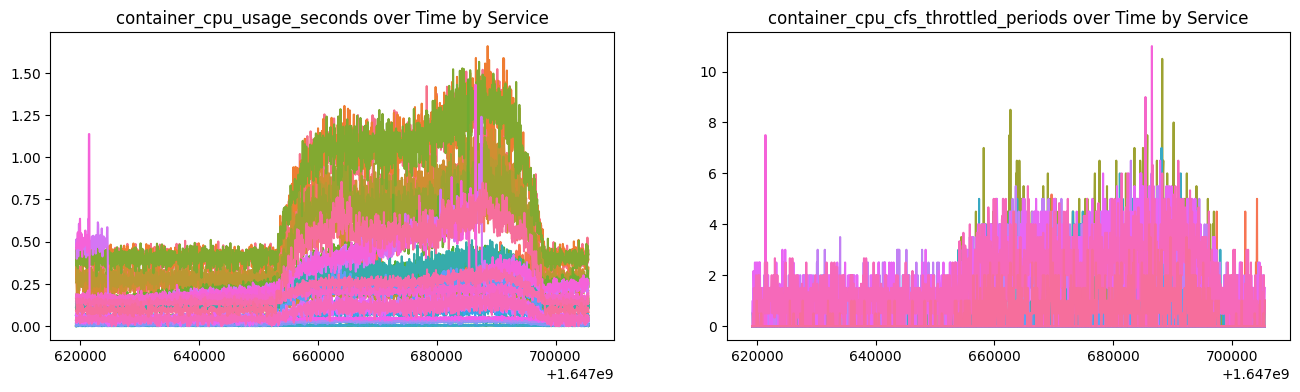

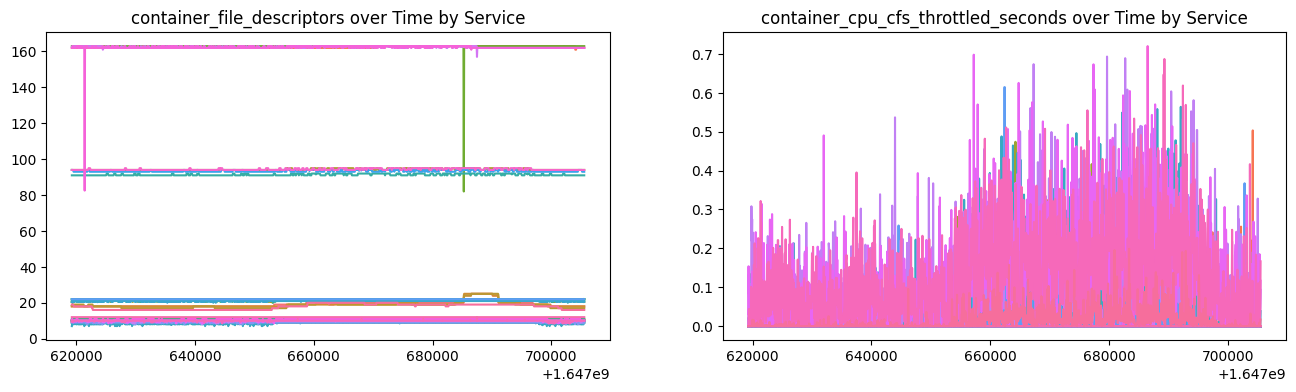

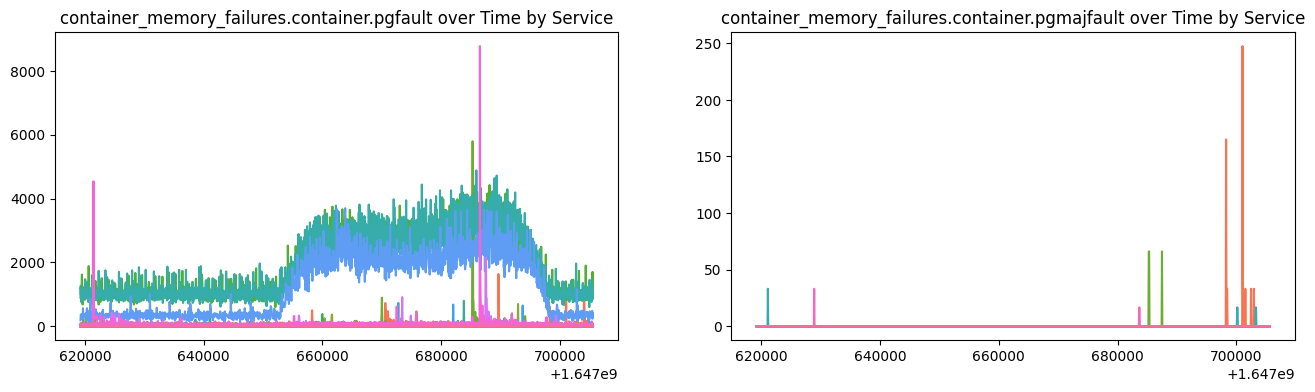

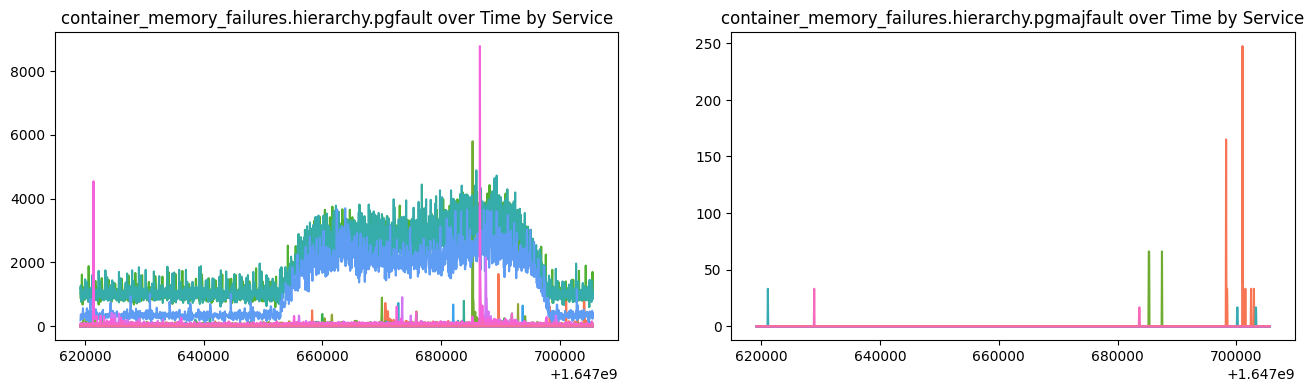

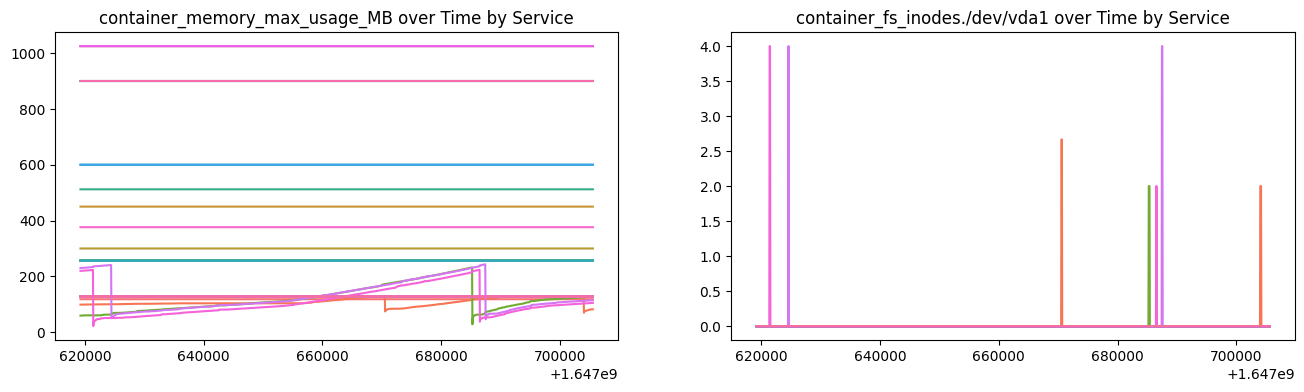

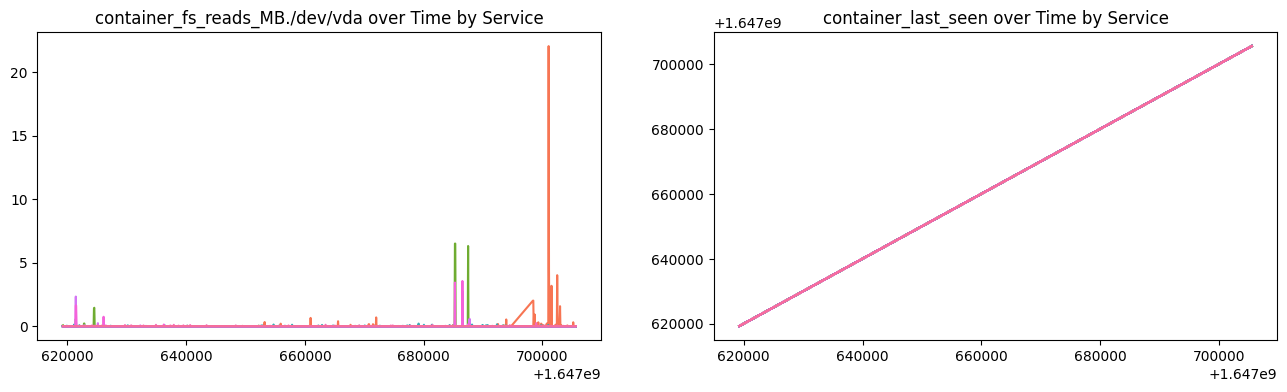

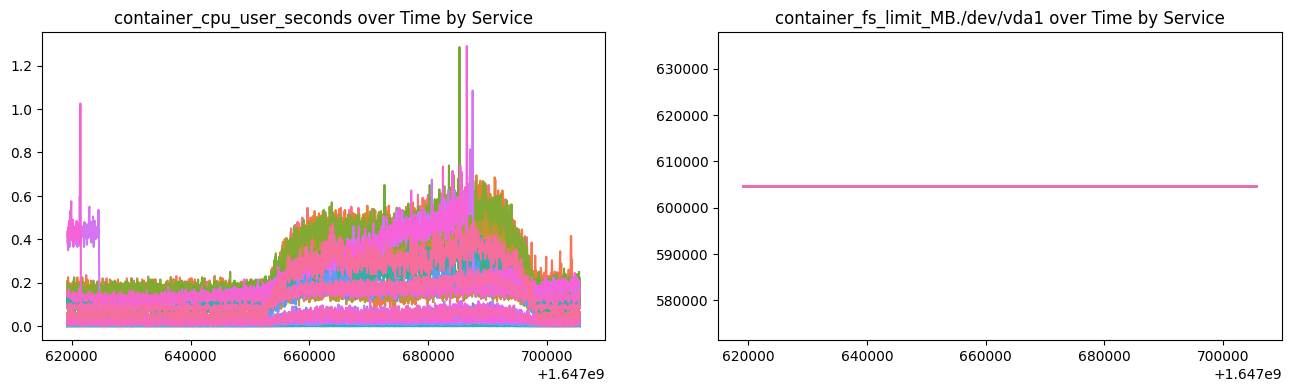

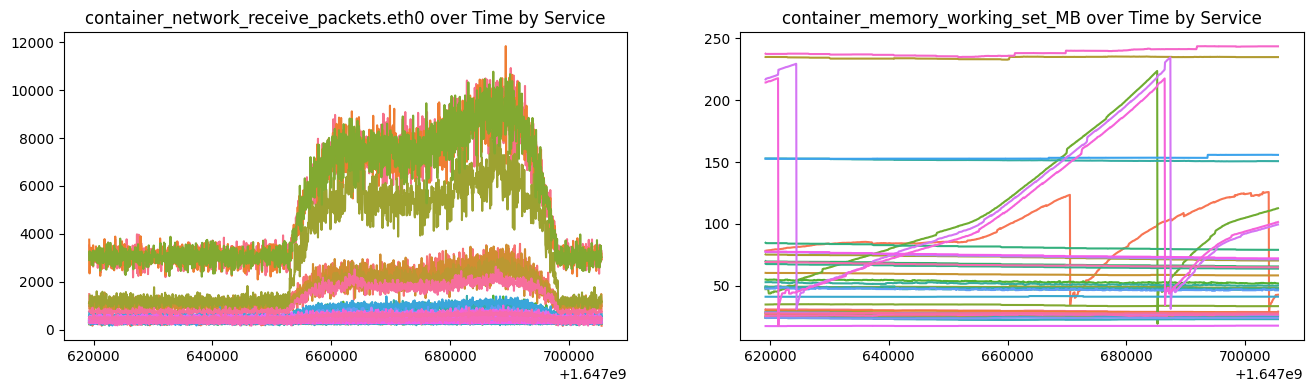

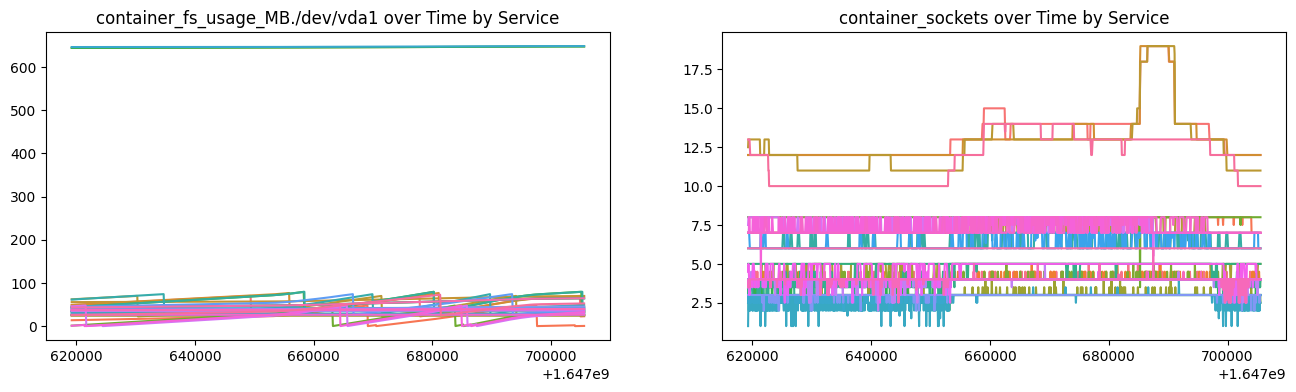

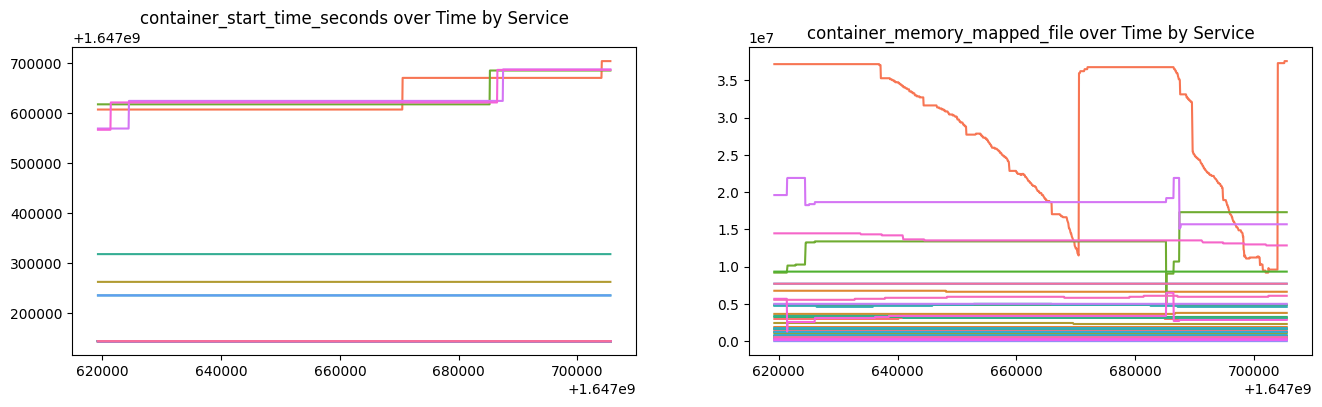

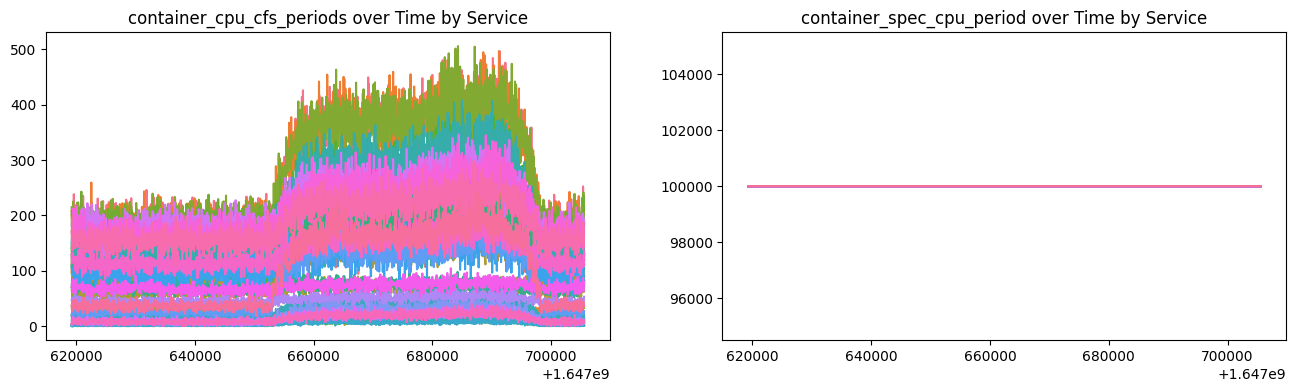

In [5]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices using a LSTM AE. This model will return a series of anomaly scores over time and a boolean which indicates whether the threshold was breached.

Then a root cause analasis starts. The edges and nodes of the topology graph will be given weights. The nodes of this graph will be ranked by PageRank.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns.

In [6]:
class DataManager:
    def __init__(self, 
                 data_path: str,
                 train: bool = False,
                 ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns
        self.train = train

        # Load from file
        self.data: Dict[str, np.ndarray] = {}
        self.columns: List[str] = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        if self.train:
            df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            self.data[file[:-4]] = cur_df[self.columns].values

    def get(self, s: str) -> np.ndarray:
        return self.data[s]

###3.2 Anomaly detection

The anomaly detection model uses two classes:
- $LSTMAEDetector$ holds a LSTM AE to detect anomolies in a microservice. Before fitting the model, it first prepares the input data by scaling and creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled so all microservices can use the same threshold. To make a prediction, the data is prepared the same way and the scaled reconstruction loss of the model is calculated. This will be the anomaly score. All the anomaly scores will be returned and it will also check whether the threshold was breached at any point.

- The anomaly detector class will create and fit the LSTM AE Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return whether they encountered an anomaly and their anomaly scores.





In [ ]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        # Compute pairwise distances between data points
        distances = pairwise_distances(data)

        # Use DBSCAN for clustering
        self.detector = DBSCAN(eps=0.5, min_samples=5)
        self.detector.fit(distances)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        distances = pairwise_distances(data)
        labels = self.detector.labels_

        # Calculate anomaly scores based on cluster membership
        anomaly_scores = np.zeros_like(labels, dtype=float)
        unique_labels = np.unique(labels)

        for label in unique_labels:
            if label == -1:  # Outliers
                anomaly_scores[labels == label] = 1.0
            else:
                cluster_indices = np.where(labels == label)[0]
                cluster_distances = distances[cluster_indices][:, cluster_indices]
                min_distances = np.min(cluster_distances, axis=1)
                max_distance = np.max(min_distances)
                anomaly_scores[labels == label] = 1.0 - min_distances / max_distance

        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [ ]:
# GRAPH BASED DETECTOR

from sklearn.neighbors import LocalOutlierFactor

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = LocalOutlierFactor(contamination='auto')
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.negative_outlier_factor_
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [ ]:
# SVM BASED DETECTOR

from sklearn.svm import OneClassSVM

class SVMBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = OneClassSVM(nu=0.1)
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = SVMBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result

In [ ]:
# ISOLATION FOREST

from sklearn.ensemble import IsolationForest

class IsolationForestDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = IsolationForest()
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = IsolationForestDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies = {}
        anomaly_scores = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        result = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)
            assert isinstance(detect_result, np.ndarray)
            result[k] = np.mean(detect_result)

        return result


In [ ]:
# K SIGMA DETECTOR

class KSigmaDetecor:
    def __init__(self):
        pass

    def fit(self, data: np.ndarray):
        self.lam = np.mean(data, axis=0, keepdims=True)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]

        data_lam = np.mean(data, axis=0, keepdims=True)

        return np.ones_like(data_lam) - np.exp(-1*np.square(np.sqrt(self.lam) - np.sqrt(data_lam)))


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, KSigmaDetecor] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = KSigmaDetecor()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result

In [ ]:
# SHUFFLING AUTOENCODER

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class AutoencoderDetector:
    def __init__(self, input_dim, hidden_dim):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def fit(self, data):
        x = torch.tensor(data, dtype=torch.float).to(self.device)

        # Normalize input features
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        x = torch.tensor(x, dtype=torch.float).to(self.device)

        # Create Autoencoder model
        self.model = Autoencoder(self.input_dim, self.hidden_dim).to(self.device)

        # Train the model
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        criterion = nn.MSELoss()

        num_epochs = 20
        batch_size = 64
        num_batches = len(x) // batch_size

        for epoch in range(num_epochs):
            np.random.shuffle(x)
            total_loss = 0

            for i in range(num_batches):
                batch = x[i * batch_size: (i + 1) * batch_size]
                optimizer.zero_grad()
                recon_batch = self.model(batch)
                loss = criterion(recon_batch, batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / num_batches
            print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    def decision_function(self, data):
        x = torch.tensor(data, dtype=torch.float).to(self.device)
        self.model.eval()
        with torch.no_grad():
            recon_data = self.model(x)

        reconstruction_error = torch.mean(torch.square(recon_data - x), dim=1)
        anomaly_scores = 1.0 - torch.exp(-reconstruction_error)
        return anomaly_scores.cpu().numpy()


class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict = {}

    def fit(self, data):
        hidden_dim = self.hyper_params.get('hidden_dim', 16)
        for key in tqdm(data.data.keys(), desc='Fitting detector(s)'):
            detector = AutoencoderDetector(data.get(key).shape[1], hidden_dim)
            detector.fit(data.get(key))
            self.detector_dict[key] = detector

    def decision_function(self, data):
        anomalies = {}
        anomaly_scores = {}

        for key, values in data.data.items():
            detector = self.detector_dict[key]
            scores = detector.decision_function(values)
            anomaly_scores[key] = scores
            anomalies[key] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data):
        result = {}

        for key, values in data.data.items():
            detect_result = self.detector_dict[key].decision_function(values)
            assert isinstance(detect_result, np.ndarray)
            result[key] = np.mean(detect_result)

        return result


In [ ]:
# GRAPH SAGE - K SIGMA

import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from typing import Dict
from tqdm import tqdm


class KSigmaDetector:
    def __init__(self, hidden_dim=16):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.hidden_dim = hidden_dim
        self.input_dim = None

    def fit(self, data: np.ndarray):
        num_nodes, self.input_dim = data.shape

        x = torch.tensor(data, dtype=torch.float).to(self.device)

        # Normalize input features
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        x = torch.tensor(x, dtype=torch.float).to(self.device)

        # Create GraphSAGE model
        self.model = GraphSAGE(self.input_dim, self.hidden_dim).to(self.device)

        # Train the model
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

        for epoch in range(20):
            optimizer.zero_grad()
            out = self.model(x)
            loss = F.mse_loss(out, x)
            loss.backward()
            optimizer.step()

        self.lam = np.mean(data, axis=0, keepdims=True)

    def decision_function(self, data: np.ndarray):
        x = torch.tensor(data, dtype=torch.float).to(self.device)

        self.model.eval()
        with torch.no_grad():
            out = self.model(x)

        data_lam = np.mean(data, axis=0, keepdims=True)

        reconstruction_error = torch.mean(torch.square(out - x), dim=1)
        anomaly_scores = np.ones_like(data_lam) - np.exp(-1 * np.square(np.sqrt(self.lam) - np.sqrt(data_lam)))

        return anomaly_scores


class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphSAGE, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, KSigmaDetector] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = KSigmaDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert isinstance(detect_result, np.ndarray)
            result[k] = np.mean(detect_result)

        return result


###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. The ranker has to be initialized with an anomalydetector. To start ranking the microservices their anomaly scores are calculated. Afterwards, the algorithm will use following scoring formula to perform a simplified version of pagerank:

$$v_{t+1} = (1 - c)Pv_t + cu$$

where $v$ holds the score of all nodes, $P$ is a matrix holding the weights of all edges and $u$ is a vector with for each microservice, the max anomaly score. For all edges in the topology, $P$ is equal to the pearson correlation of the nodes it connects and 0 for all other edges. This means that the score for the nodes $v$ is parially defined by the anomaly score of the microservice and partially by the score of their parent nodes. However, that depends on the corralation between their anomaly scores.

This algrorithm is based on the MicroRCA algorithm, but we do not have all the data they had.

Li Wu, Johan Tordsson, Erik Elmroth, Odej Kao. MicroRCA: Root Cause Localization of Performance
Issues in Microservices. IEEE/IFIP Network Operations and Management Symposium (NOMS), Apr
2020, Budapest, Hungary. ffhal-02441640f

https://inria.hal.science/hal-02441640

In [ ]:
# SCORE SORTING

class Ranker:
    """
        This is a naive ranking algorithm, which simply rank according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params

        self.train_data = DataManager(hyper_params['train_dir'])
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):     
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)
        print(anomaly_score)

        # TODO: You need to modify the ranking algorithm to achieve better results!   
        # This is a naive ranking algorithm, which simply rank according to the anomaly scores.
        rank_result = sorted(list(anomaly_score.keys()), key=lambda x: anomaly_score[x], reverse=True)

        return rank_result


In [ ]:
def find_correlation(container1: np.ndarray, container2: np.ndarray):
    corr = []
    for i in range(container1.shape[1]):
        if not np.all(container1[:, i] == container1[0, i]) and not np.all(container2[:, i] == container1[0, i]):
              corr.append(abs(pearsonr(container1[:, i].flatten(), container1[:, i].flatten())[0]))
    return sum(corr)/len(corr)


class Ranker:
    """
        This is a naive ranking algorithm, which simply rank according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.train_data = DataManager(hyper_params['train_dir'], True)
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)

        services = list(anomaly_score.keys())

        max_anomaly = max(anomaly_score, key=anomaly_score.get)

        weights = {}

        for service in services:
            weights[service] = find_correlation(test_data.data[service], test_data.data[max_anomaly])

        # Find P and u for pagerank
        P = np.zeros((len(services), len(services)))
        v = np.ones((len(services), 1))
        u = np.ones((len(services), 1))

        with open(self.hyper_params['topology'], 'rt') as f:
            topology = json.load(f)

        for i, service in enumerate(services):
            P[i][i] = weights[service]
            u[i] = anomaly_score[service]
            # v[i] = anomaly_score[service]
            for key, values in topology.items():
                if service.startswith(key):
                    for value in values:
                        for j, s in enumerate(services):
                            if s.startswith(value):
                                P[j][i] = weights[s]

        P = (P.T / P.sum(axis=1)).T
        c = 0.3

        for _ in range(10):
            v = (1-c)*np.matmul(P, v) + u*c/len(services)

        # Rank services based on their page rank score
        scores = {services[i]: v[i][0] for i in range(len(services))}

        rank_result = sorted(list(scores.keys()), key=lambda x: scores[x], reverse=True)

        return rank_result

In [ ]:
def find_correlation(container1: np.ndarray, container2: np.ndarray):
    corr = []
    for i in range(container1.shape[1]):
        if not np.all(container1[:, i] == container1[0, i]) and not np.all(container2[:, i] == container1[0, i]):
              corr.append(abs(pearsonr(container1[:, i].flatten(), container1[:, i].flatten())[0]))
    return sum(corr)/len(corr)


class Ranker:
    """
        This is a naive ranking algorithm, which simply rank according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.train_data = DataManager(hyper_params['train_dir'], True)
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)

        services = list(anomaly_score.keys())

        max_anomaly = max(anomaly_score, key=anomaly_score.get)

        weights = {}

        for service in services:
            weights[service] = find_correlation(test_data.data[service], test_data.data[max_anomaly])

        # Find P and u for pagerank
        P = np.zeros((len(services), len(services)))
        v = np.ones((len(services), 1))
        u = np.ones((len(services), 1))

        with open(self.hyper_params['topology'], 'rt') as f:
            topology = json.load(f)

        for i, service in enumerate(services):
            P[i][i] = weights[service]
            u[i] = weights[service]
            # v[i] = anomaly_score[service]
            for key, values in topology.items():
                if service.startswith(key):
                    for value in values:
                        for j, s in enumerate(services):
                            if s.startswith(value):
                                P[j][i] = weights[s]
                                P[i][j] = 0.1*weights[s]

        P = (P.T / P.sum(axis=1)).T
        c = 0.3

        for _ in range(10):
            v = (1-c)*np.matmul(P, v) + u*c/len(services)

        # Rank services based on their page rank score
        scores = {services[i]: v[i][0] for i in range(len(services))}

        rank_result = sorted(list(scores.keys()), key=lambda x: scores[x], reverse=True)

        return rank_result

https://netman.aiops.org/~peidan/ANM2023/7.TraceAnomalyDetection/LectureCoverage/2013SIGMETRICS13_Root%20Cause%20Detection%20in%20a%20Service-Oriented%20Architecture.pdf

In [10]:
def find_correlation(container1: np.ndarray, container2: np.ndarray):
    corr = []
    for i in range(container1.shape[1]):
        if not np.all(container1[:, i] == container1[0, i]) and not np.all(container2[:, i] == container1[0, i]):
              corr.append(abs(pearsonr(container1[:, i].flatten(), container1[:, i].flatten())[0]))
    return sum(corr)/len(corr)

# Monitor rank
class Ranker:
    """
        This is a naive ranking algorithm, which simply rank according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.train_data = DataManager(hyper_params['train_dir'], True)
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

        self.services = list(self.train_data.data.keys())
        self.A = np.zeros((len(self.services), len(self.services)))
        self.rho = 0.3
        with open(self.hyper_params['topology'], 'rt') as f:
            topology = json.load(f)

        for i, service in enumerate(self.services):
            for key, values in topology.items():
                if service.startswith(key):
                    for value in values:
                        for j, s in enumerate(self.services):
                            if s.startswith(value):
                                self.A[i][j] = 1

    def rank(self, case_dir: str):
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)

        max_anomaly = max(anomaly_score, key=anomaly_score.get)

        # Find Q
        S = np.empty(len(self.services))
        u = np.empty(len(self.services))

        for i, service in enumerate(self.services):
            S[i] = find_correlation(test_data.data[service], test_data.data[max_anomaly])
            u[i] = anomaly_score[service]

        Q = self.A*S

        for i in range(len(self.services)):
            Q[i][i] = max(0, S[i] - np.max(Q[:][i]))

        Q = Q + (self.A.T*S*self.rho)

        Q = (Q.T / (Q.sum(axis=1) + 1e-5)).T

        v = np.ones(len(self.services))
        alpha = 0.8

        for _ in range(10):
            v = alpha*np.matmul(v, Q) + S*(1-alpha)

        # Rank services based on their page rank score
        scores = {self.services[i]: v[i] for i in range(len(self.services))}

        rank_result = sorted(list(scores.keys()), key=lambda x: scores[x], reverse=True)

        return rank_result

In [ ]:
# RANDOM WALK RANKER

import random

class Ranker:
    """
        This is a ranking algorithm that uses random walk for anomaly ranking.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params

        self.train_data = DataManager(hyper_params['train_dir'])
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self.topology = self._load_topology()
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):     
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)
        print(anomaly_score)

        # Perform random walk for all containers
        ranked_items = []
        for item, score in anomaly_score.items():
            visitation_frequency = self._perform_random_walk(item, anomaly_score)
            ranked_items.append((item, visitation_frequency))

        # Sort the ranked items based on the visitation frequencies from random walk
        ranked_items.sort(key=lambda x: x[1], reverse=True)

        # Return the ranked items
        ranked_items = [item for item, _ in ranked_items]
        return ranked_items

    def _perform_random_walk(self, item, anomaly_score):
        # Hard-coded number of random walks and steps
        num_walks = 100
        num_steps = 100

        visitation_frequency = 0

        for _ in range(num_walks):
            current_item = item

            # Perform random walk for the given number of steps
            for _ in range(num_steps):
                # Check if the current item is anomalous
                if current_item in anomaly_score:
                    visitation_frequency += 1

                # Get the neighbors of the current item
                neighbors = self._get_neighbors(current_item)

                # Choose a random neighbor
                if neighbors:
                    current_item = random.choice(neighbors)
                else:
                    break

        return visitation_frequency

    def _get_neighbors(self, service):
        if service in self.topology:
            neighbors = self.topology[service]
            # Randomly shuffle the list of neighbors
            random.shuffle(neighbors)
            return neighbors
        else:
            return []

    def _load_topology(self):
        topology_file = self.hyper_params['topology']
        with open(topology_file, 'r') as file:
            topology_data = json.load(file)
        return topology_data



###3.4 Training

In [11]:
"""
hyper_params = {
    'train_dir': 'phase2/dataset/train/processed',
    'test_dir': 'phase2/dataset/test/processed',
    'label_path': 'phase2/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}
"""

hyper_params = {
    'train_dir': 'phase1/dataset/train/processed',
    'test_dir': 'phase1/dataset/test/processed',
    'label_path': 'phase1/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}



ranker = Ranker(hyper_params)

Fitting detector(s): 100%|██████████| 42/42 [00:00<00:00, 6741.19it/s]


##4. evaluation, prediction and metrics

- evaluate test set anomalies and rank them
- compare labels with predicted ranking
- information regarding indexing are provided

In [ ]:
class Evaluator:
    """
        Evaluate the localization algorithm with the give label.
    """
    def __init__(self, label_path: str):
        self.label_path = label_path

        with open(self.label_path, 'rt') as f:
            self.label = json.load(f)

    def evaluate(self, detect_results: List[List[str]], topk: List[int] = [1, 10, 20], write_report: bool=False):
        """
            Input: List of cases. Each case is a ranked list of root causes from the most likely ones to the least likely ones.
            Print the evaluation result.
        """
        all_ranks: List[int] = []
        topk_hit: List[List[int]] = []

        for i, case in enumerate(detect_results):
            cur_label = self.label['cmdb_id'][i]

            # Cur_rank is the rank of current case. Default is length of the list + 1.
            cur_rank = len(case) + 1
            for rank, root_cause in enumerate(case):
                if cur_label in root_cause:
                    cur_rank = rank + 1
                    break
            
            all_ranks.append(cur_rank)
            
            # Calculate the topk hit for current case.
            cur_topk_hit = []
            for k in topk:
                if cur_rank <= k:
                    cur_topk_hit.append(1)
                else:
                    cur_topk_hit.append(0)
            topk_hit.append(cur_topk_hit)

            # Write report if true
            if write_report:
                os.makedirs("report", exist_ok=True)
                report_content = f"Label: {cur_label}\n========List=======\n"
                for rank, root_cause in enumerate(case):
                    report_content += f"{rank}: {root_cause}\n"
                    if cur_label in root_cause:
                        report_content += "^ ROOT CAUSE\n"
                with open(os.path.join("report", f"{i}.txt"), "wt") as f:
                    f.write(report_content)

        # Calculate the average results
        mrr = np.mean(1 / np.array(all_ranks))
        avg_topk_hit = np.mean(topk_hit, axis=0)

        # Report the result
        report: str = "--------------Report-------------\n"
        for i in range(len(all_ranks)):
            report += f"Case {i}: "
            for j, k in enumerate(topk):
                report += f"Top {k}: {topk_hit[i][j]}\t"
            report += f"Rank: {all_ranks[i]}\n"

        report += "============AVG=============="
        for j, k in enumerate(topk):
            report += f"Top {k}: {avg_topk_hit[j]:.4f}, "
        report += f"MRR: {mrr:.4f}"
        print(report)

In [12]:
# Generate a list of lists containing the labels for the test set of phase 1 only
# Load the JSON file
with open('phase1/dataset/test/label.json', 'r') as json_file:
    data = json.load(json_file)

df_labels = pd.DataFrame(data)
labels = df_labels.values.tolist()

print(labels)

[[1648486942, 'emailservice-0'], [1648491433, 'recommendationservice2-0'], [1648492533, 'currencyservice-1'], [1648507813, 'paymentservice-1'], [1648512399, 'productcatalogservice-0'], [1648518075, 'shippingservice2-0'], [1648520175, 'productcatalogservice-0'], [1648522456, 'paymentservice-0'], [1648525065, 'frontend2-0'], [1648540678, 'shippingservice-2'], [1648541744, 'frontend2-0'], [1648552790, 'adservice2-0'], [1648558337, 'recommendationservice-2'], [1648560649, 'cartservice-2'], [1648561519, 'emailservice-2'], [1648565706, 'frontend2-0'], [1648550137, 'cartservice-1'], [1648525567, 'cartservice-1'], [1648491097, 'paymentservice-2'], [1648494319, 'adservice-2'], [1648506344, 'productcatalogservice-1'], [1648516367, 'productcatalogservice-0'], [1648528148, 'recommendationservice-1'], [1648528984, 'shippingservice-2'], [1648531433, 'cartservice-2'], [1648540897, 'shippingservice-2'], [1648549152, 'emailservice-2'], [1648551076, 'shippingservice-2'], [1648552118, 'recommendationserv

In [13]:
result_list = []
case_idx: int = 0
with tqdm(total=len(os.listdir(hyper_params['test_dir']))) as t:
    while True:
        case_dir = os.path.join(hyper_params['test_dir'], str(case_idx))
        if not os.path.exists(case_dir):
            break
        t.set_description(f"Ranking {case_dir}")

        cur_rank = ranker.rank(case_dir)
        print("")
        print("the anomaly label is: ", labels[case_idx])
        print(cur_rank)
        for l in cur_rank:
          if l == labels[case_idx][1]:
            print("in the current rank, the original amonaly is in position ", cur_rank.index(l))
            break
        print("\n")
        result_list.append(cur_rank)

        # Update tqdm
        t.update()
        case_idx += 1

evaluator = Evaluator(hyper_params['label_path'])

evaluator.evaluate(result_list)

Ranking phase2/dataset/test/processed/1:   2%|▏         | 1/61 [00:00<00:09,  6.50it/s]

{'productcatalogservice-0': 0.17693501155871677, 'frontend-2': 0.22937237440976024, 'cartservice2-0': 0.2099556121242289, 'productcatalogservice-1': 0.1833963729188136, 'shippingservice-1': 0.1902004727566951, 'frontend-1': 0.21428279963033173, 'recommendationservice2-0': 0.1512996062269975, 'frontend-0': 0.23257211242697737, 'adservice2-0': 0.17539320279142537, 'emailservice-1': 0.1304597229508895, 'productcatalogservice2-0': 0.17694798795734748, 'paymentservice-0': 0.15961347861959144, 'productcatalogservice-2': 0.18883381355147483, 'cartservice-1': 0.22746665068733257, 'currencyservice-0': 0.19351684255676985, 'paymentservice-1': 0.16719460903727676, 'recommendationservice-0': 0.16109947642811526, 'recommendationservice-1': 0.18107622606201246, 'emailservice2-0': 0.15845021488588643, 'paymentservice-2': 0.1952916434398506, 'currencyservice-1': 0.19259420723113804, 'adservice-1': 0.18295079896135505, 'currencyservice-2': 0.18953044519284687, 'shippingservice-2': 0.1842416865791423, '

Ranking phase2/dataset/test/processed/2:   3%|▎         | 2/61 [00:00<00:09,  6.43it/s]

{'productcatalogservice-0': 0.1766717625943657, 'frontend-2': 0.22866296216492754, 'cartservice2-0': 0.20004825220946418, 'productcatalogservice-1': 0.18383452894353258, 'shippingservice-1': 0.1905456706306347, 'frontend-1': 0.21689380158618093, 'recommendationservice2-0': 0.17158943810888014, 'frontend-0': 0.2194133917766034, 'adservice2-0': 0.17039224099855518, 'emailservice-1': 0.13511145445983674, 'productcatalogservice2-0': 0.1781987902933175, 'paymentservice-0': 0.15767724296768687, 'productcatalogservice-2': 0.18811357240296658, 'cartservice-1': 0.22567959220589723, 'currencyservice-0': 0.19451101339521099, 'paymentservice-1': 0.16135233645098662, 'recommendationservice-0': 0.17730594377304834, 'recommendationservice-1': 0.16052502439023816, 'emailservice2-0': 0.15868812008304276, 'paymentservice-2': 0.19478694342805367, 'currencyservice-1': 0.1910169425375236, 'adservice-1': 0.18464412726844712, 'currencyservice-2': 0.18954696410166771, 'shippingservice-2': 0.18865551537895595,

Ranking phase2/dataset/test/processed/3:   5%|▍         | 3/61 [00:00<00:08,  6.57it/s]

{'productcatalogservice-0': 0.17554589063390127, 'frontend-2': 0.22790022757772663, 'cartservice2-0': 0.2199555608234763, 'productcatalogservice-1': 0.18284995220515335, 'shippingservice-1': 0.18848163436801593, 'frontend-1': 0.21529489706469135, 'recommendationservice2-0': 0.18203526749286525, 'frontend-0': 0.21870957196021684, 'adservice2-0': 0.18951223800087352, 'emailservice-1': 0.13758475929108566, 'productcatalogservice2-0': 0.19140416134939187, 'paymentservice-0': 0.1573781999740356, 'productcatalogservice-2': 0.1871092462256448, 'cartservice-1': 0.2249613286599761, 'currencyservice-0': 0.19415381216423042, 'paymentservice-1': 0.15777411147729428, 'recommendationservice-0': 0.17707532497412454, 'recommendationservice-1': 0.16353169231612616, 'emailservice2-0': 0.16167201957142827, 'paymentservice-2': 0.19331396423591488, 'currencyservice-1': 0.19073077467587948, 'adservice-1': 0.18354962366965874, 'currencyservice-2': 0.18925445412099176, 'shippingservice-2': 0.18711739711884845

Ranking phase2/dataset/test/processed/4:   7%|▋         | 4/61 [00:00<00:09,  6.32it/s]

{'productcatalogservice-0': 0.1768840321073865, 'frontend-2': 0.22853136596024365, 'cartservice2-0': 0.2254207868605858, 'productcatalogservice-1': 0.18445635950615208, 'shippingservice-1': 0.19004927849157197, 'frontend-1': 0.2175354763824404, 'recommendationservice2-0': 0.1785348728805949, 'frontend-0': 0.2131110714349575, 'adservice2-0': 0.17579145795460555, 'emailservice-1': 0.13732486516512213, 'productcatalogservice2-0': 0.19099708008991012, 'paymentservice-0': 0.15793303300707554, 'productcatalogservice-2': 0.18815731508854514, 'cartservice-1': 0.22360245473807314, 'currencyservice-0': 0.19443136245745535, 'paymentservice-1': 0.1600226645159213, 'recommendationservice-0': 0.17040641996387587, 'recommendationservice-1': 0.16846086444256325, 'emailservice2-0': 0.16288019453410016, 'paymentservice-2': 0.19427679417530783, 'currencyservice-1': 0.19199546628197467, 'adservice-1': 0.17031870563882676, 'currencyservice-2': 0.18969825782702895, 'shippingservice-2': 0.1882839456606273, '

Ranking phase2/dataset/test/processed/5:   8%|▊         | 5/61 [00:00<00:08,  6.29it/s]

{'productcatalogservice-0': 0.17475821352071852, 'frontend-2': 0.2314219301803085, 'cartservice2-0': 0.1983629499332711, 'productcatalogservice-1': 0.18469872867481146, 'shippingservice-1': 0.18603920731411536, 'frontend-1': 0.19500690511208224, 'recommendationservice2-0': 0.16019998205790079, 'frontend-0': 0.20119526444699717, 'adservice2-0': 0.18594297765444942, 'emailservice-1': 0.14524104491251186, 'productcatalogservice2-0': 0.19007274841622318, 'paymentservice-0': 0.15404411866186543, 'productcatalogservice-2': 0.18765174678407426, 'cartservice-1': 0.2050593327139673, 'currencyservice-0': 0.19360927051404278, 'paymentservice-1': 0.1573811824777935, 'recommendationservice-0': 0.15685317254344644, 'recommendationservice-1': 0.17666907355447445, 'emailservice2-0': 0.15946663413612866, 'paymentservice-2': 0.18909864907828663, 'currencyservice-1': 0.1941735605021804, 'adservice-1': 0.18269347932650468, 'currencyservice-2': 0.26921906415775493, 'shippingservice-2': 0.18604813978637244,

Ranking phase2/dataset/test/processed/6:  10%|▉         | 6/61 [00:00<00:08,  6.32it/s]

{'productcatalogservice-0': 0.1708145701000578, 'frontend-2': 0.25248445960614907, 'cartservice2-0': 0.18682703257927002, 'productcatalogservice-1': 0.17984494656859884, 'shippingservice-1': 0.15051783712477296, 'frontend-1': 0.19186931379297548, 'recommendationservice2-0': 0.29869057660343057, 'frontend-0': 0.20306459391435366, 'adservice2-0': 0.22528873266220012, 'emailservice-1': 0.1388725244345154, 'productcatalogservice2-0': 0.18692912879745874, 'paymentservice-0': 0.12605085973647906, 'productcatalogservice-2': 0.18316465447131375, 'cartservice-1': 0.12114048630271546, 'currencyservice-0': 0.1825735092818588, 'paymentservice-1': 0.1395394246346985, 'recommendationservice-0': 0.2748121676646993, 'recommendationservice-1': 0.2796061320269032, 'emailservice2-0': 0.15427812325815865, 'paymentservice-2': 0.16862376084421213, 'currencyservice-1': 0.175029551540622, 'adservice-1': 0.1644803122271294, 'currencyservice-2': 0.18184152134068066, 'shippingservice-2': 0.14974050803577674, 'sh

Ranking phase2/dataset/test/processed/7:  11%|█▏        | 7/61 [00:01<00:08,  6.39it/s]

{'productcatalogservice-0': 0.1617200784424617, 'frontend-2': 0.2114271501405963, 'cartservice2-0': 0.1982861269053245, 'productcatalogservice-1': 0.15246497160553815, 'shippingservice-1': 0.15395179803389847, 'frontend-1': 0.16364027253391505, 'recommendationservice2-0': 0.18389411532561775, 'frontend-0': 0.15924637031514594, 'adservice2-0': 0.2283432795935001, 'emailservice-1': 0.1393212829217906, 'productcatalogservice2-0': 0.20404731245271052, 'paymentservice-0': 0.11343823881789239, 'productcatalogservice-2': 0.1703266716116667, 'cartservice-1': 0.11544205775964637, 'currencyservice-0': 0.14291294164139226, 'paymentservice-1': 0.11914082171440848, 'recommendationservice-0': 0.14060658063065748, 'recommendationservice-1': 0.19851036427191546, 'emailservice2-0': 0.15195992231813213, 'paymentservice-2': 0.15416760430622356, 'currencyservice-1': 0.14938177317505325, 'adservice-1': 0.14143931895979064, 'currencyservice-2': 0.15550303316461445, 'shippingservice-2': 0.1529233437778508, '

Ranking phase2/dataset/test/processed/8:  13%|█▎        | 8/61 [00:01<00:08,  6.45it/s]

{'productcatalogservice-0': 0.15531738517842372, 'frontend-2': 0.2203737692091574, 'cartservice2-0': 0.23809293662986322, 'productcatalogservice-1': 0.151629684560123, 'shippingservice-1': 0.20397212712244475, 'frontend-1': 0.18760201798236875, 'recommendationservice2-0': 0.17830525034657482, 'frontend-0': 0.18426377280838596, 'adservice2-0': 0.23772606558741463, 'emailservice-1': 0.1399551342671678, 'productcatalogservice2-0': 0.2251122037185617, 'paymentservice-0': 0.12651568675240915, 'productcatalogservice-2': 0.16866418482818246, 'cartservice-1': 0.1595068319284076, 'currencyservice-0': 0.18372161040563004, 'paymentservice-1': 0.133776144091229, 'recommendationservice-0': 0.15549271077359417, 'recommendationservice-1': 0.15597344727253726, 'emailservice2-0': 0.15042242721089388, 'paymentservice-2': 0.17033140641350797, 'currencyservice-1': 0.19240904420899974, 'adservice-1': 0.1692931716983491, 'currencyservice-2': 0.1957693022394946, 'shippingservice-2': 0.19305021945220532, 'shi

Ranking phase2/dataset/test/processed/9:  15%|█▍        | 9/61 [00:01<00:08,  6.39it/s]

{'productcatalogservice-0': 0.15592258313698104, 'frontend-2': 0.22372999232612084, 'cartservice2-0': 0.23238259109748174, 'productcatalogservice-1': 0.16645971643097263, 'shippingservice-1': 0.20124271033194166, 'frontend-1': 0.18797869365644554, 'recommendationservice2-0': 0.17470918837355606, 'frontend-0': 0.1819049839464035, 'adservice2-0': 0.19733699143411002, 'emailservice-1': 0.14451207410509426, 'productcatalogservice2-0': 0.22376572275291967, 'paymentservice-0': 0.12900180228027994, 'productcatalogservice-2': 0.169322792917067, 'cartservice-1': 0.16909258207547348, 'currencyservice-0': 0.19266594486038663, 'paymentservice-1': 0.13414534223718422, 'recommendationservice-0': 0.15378140548225167, 'recommendationservice-1': 0.15982620479109863, 'emailservice2-0': 0.15233261975809878, 'paymentservice-2': 0.1714220825290662, 'currencyservice-1': 0.1934130564334032, 'adservice-1': 0.16040994242348083, 'currencyservice-2': 0.19414478901746032, 'shippingservice-2': 0.19348178502024502,

Ranking phase2/dataset/test/processed/10:  16%|█▋        | 10/61 [00:01<00:07,  6.44it/s]

{'productcatalogservice-0': 0.15606073793437825, 'frontend-2': 0.224183681624531, 'cartservice2-0': 0.21933197120794828, 'productcatalogservice-1': 0.16682939427770638, 'shippingservice-1': 0.1933456988330553, 'frontend-1': 0.18755376373564553, 'recommendationservice2-0': 0.1747675693562016, 'frontend-0': 0.18522503930790649, 'adservice2-0': 0.1981248083588355, 'emailservice-1': 0.14468621062271356, 'productcatalogservice2-0': 0.2257322772189692, 'paymentservice-0': 0.12060200048850361, 'productcatalogservice-2': 0.1687998749931436, 'cartservice-1': 0.17180926654567863, 'currencyservice-0': 0.23081369889864395, 'paymentservice-1': 0.1330405388143198, 'recommendationservice-0': 0.15312085189724084, 'recommendationservice-1': 0.15814469131524472, 'emailservice2-0': 0.15082302909136058, 'paymentservice-2': 0.16899966774613082, 'currencyservice-1': 0.3134917706532507, 'adservice-1': 0.1586141265525568, 'currencyservice-2': 0.24140786352033966, 'shippingservice-2': 0.1942699210831597, 'ship

Ranking phase2/dataset/test/processed/11:  18%|█▊        | 11/61 [00:01<00:07,  6.41it/s]

{'productcatalogservice-0': 0.16708403316739737, 'frontend-2': 0.22901369824608703, 'cartservice2-0': 0.19412599505625286, 'productcatalogservice-1': 0.16704984828741273, 'shippingservice-1': 0.17471772319942575, 'frontend-1': 0.1589718300657322, 'recommendationservice2-0': 0.16602718453877974, 'frontend-0': 0.16563018850417502, 'adservice2-0': 0.17754894616284264, 'emailservice-1': 0.13928317710220514, 'productcatalogservice2-0': 0.19977528257459223, 'paymentservice-0': 0.11566295492919357, 'productcatalogservice-2': 0.17845063632329342, 'cartservice-1': 0.13622317799234782, 'currencyservice-0': 0.15375490214276538, 'paymentservice-1': 0.11849042138030404, 'recommendationservice-0': 0.11657060652037703, 'recommendationservice-1': 0.13609878407507553, 'emailservice2-0': 0.15258546350136004, 'paymentservice-2': 0.15394235834984105, 'currencyservice-1': 0.14932372600759433, 'adservice-1': 0.1254701041424502, 'currencyservice-2': 0.1569840765502146, 'shippingservice-2': 0.1713221189754328

Ranking phase2/dataset/test/processed/12:  20%|█▉        | 12/61 [00:01<00:07,  6.45it/s]

{'productcatalogservice-0': 0.13899859014758303, 'frontend-2': 0.1888649389000304, 'cartservice2-0': 0.23863037034765586, 'productcatalogservice-1': 0.1490786884011199, 'shippingservice-1': 0.14507297472980024, 'frontend-1': 0.1945310153230982, 'recommendationservice2-0': 0.19551885467862207, 'frontend-0': 0.20104501927883425, 'adservice2-0': 0.30685626580565056, 'emailservice-1': 0.11125327365614539, 'productcatalogservice2-0': 0.20418129103823468, 'paymentservice-0': 0.1448852191922887, 'productcatalogservice-2': 0.1433101388523162, 'cartservice-1': 0.21259258838337042, 'currencyservice-0': 0.19357759909698544, 'paymentservice-1': 0.15183399811230797, 'recommendationservice-0': 0.1540006137648012, 'recommendationservice-1': 0.16496436433128123, 'emailservice2-0': 0.11143869056545387, 'paymentservice-2': 0.11816262129035549, 'currencyservice-1': 0.18029514029813307, 'adservice-1': 0.2743878947869606, 'currencyservice-2': 0.2115941801795439, 'shippingservice-2': 0.16230704765578385, 's

Ranking phase2/dataset/test/processed/14:  23%|██▎       | 14/61 [00:02<00:08,  5.65it/s]

{'productcatalogservice-0': 0.14371381996713836, 'frontend-2': 0.2105131258262839, 'cartservice2-0': 0.2383428222111976, 'productcatalogservice-1': 0.1564627667823528, 'shippingservice-1': 0.14542480468901547, 'frontend-1': 0.17591315490795278, 'recommendationservice2-0': 0.1953592220367489, 'frontend-0': 0.19751704228240474, 'adservice2-0': 0.19450028842437686, 'emailservice-1': 0.11022056000667659, 'productcatalogservice2-0': 0.20886192050631572, 'paymentservice-0': 0.14402527173633442, 'productcatalogservice-2': 0.1433448941777315, 'cartservice-1': 0.2137996301583923, 'currencyservice-0': 0.1914022731779087, 'paymentservice-1': 0.13885602276191691, 'recommendationservice-0': 0.15537096115676163, 'recommendationservice-1': 0.16305655356158227, 'emailservice2-0': 0.111088801835066, 'paymentservice-2': 0.21633283810274379, 'currencyservice-1': 0.17808430059908098, 'adservice-1': 0.13832375664237656, 'currencyservice-2': 0.21227164563684994, 'shippingservice-2': 0.15921246612402912, 'sh

Ranking phase2/dataset/test/processed/16:  26%|██▌       | 16/61 [00:02<00:08,  5.33it/s]

{'productcatalogservice-0': 0.14346618804508904, 'frontend-2': 0.16320291446628704, 'cartservice2-0': 0.23151350784584088, 'productcatalogservice-1': 0.15619944044334738, 'shippingservice-1': 0.2678064382845545, 'frontend-1': 0.1726934826904147, 'recommendationservice2-0': 0.19489243477251708, 'frontend-0': 0.15732730418273047, 'adservice2-0': 0.18803563446763516, 'emailservice-1': 0.10898903776972302, 'productcatalogservice2-0': 0.20466624273062511, 'paymentservice-0': 0.13977567744532413, 'productcatalogservice-2': 0.14285806985805213, 'cartservice-1': 0.21562790908527824, 'currencyservice-0': 0.2087858938993726, 'paymentservice-1': 0.14684744304106587, 'recommendationservice-0': 0.15275990460937805, 'recommendationservice-1': 0.1621865581371017, 'emailservice2-0': 0.11124223957580445, 'paymentservice-2': 0.1308042559278981, 'currencyservice-1': 0.19112721994572, 'adservice-1': 0.17266311841715662, 'currencyservice-2': 0.2123114329746139, 'shippingservice-2': 0.30339652377096127, 'sh

Ranking phase2/dataset/test/processed/17:  28%|██▊       | 17/61 [00:02<00:08,  5.29it/s]

{'productcatalogservice-0': 0.14349145047796846, 'frontend-2': 0.18585826077149867, 'cartservice2-0': 0.23630380832567147, 'productcatalogservice-1': 0.15627612195660448, 'shippingservice-1': 0.2611916076599154, 'frontend-1': 0.18195716303953724, 'recommendationservice2-0': 0.19479491786661604, 'frontend-0': 0.14971059494720917, 'adservice2-0': 0.17604349577074865, 'emailservice-1': 0.09113143450468202, 'productcatalogservice2-0': 0.20439068526694232, 'paymentservice-0': 0.14222776895462425, 'productcatalogservice-2': 0.13370328934690084, 'cartservice-1': 0.21849449136895663, 'currencyservice-0': 0.20900768268696815, 'paymentservice-1': 0.13053439070337058, 'recommendationservice-0': 0.15219597154213857, 'recommendationservice-1': 0.1635232897304128, 'emailservice2-0': 0.11098409718297113, 'paymentservice-2': 0.12325036447292174, 'currencyservice-1': 0.19099006073001776, 'adservice-1': 0.17339443518747374, 'currencyservice-2': 0.21216335471226652, 'shippingservice-2': 0.156974882849956

Ranking phase2/dataset/test/processed/19:  31%|███       | 19/61 [00:03<00:08,  5.08it/s]

{'productcatalogservice-0': 0.11426781036025184, 'frontend-2': 0.20914535195048958, 'cartservice2-0': 0.22901842930056998, 'productcatalogservice-1': 0.11332266880871703, 'shippingservice-1': 0.14577258989313105, 'frontend-1': 0.1611411488608281, 'recommendationservice2-0': 0.22751976936099683, 'frontend-0': 0.19837251477662995, 'adservice2-0': 0.16691519446553252, 'emailservice-1': 0.12458059901018267, 'productcatalogservice2-0': 0.19211885760554057, 'paymentservice-0': 0.12968559215638614, 'productcatalogservice-2': 0.10451513393520119, 'cartservice-1': 0.14958637702210414, 'currencyservice-0': 0.18646596582717856, 'paymentservice-1': 0.13329140429390587, 'recommendationservice-0': 0.2043893298536288, 'recommendationservice-1': 0.2285725329973664, 'emailservice2-0': 0.12136374208905491, 'paymentservice-2': 0.11134437536366676, 'currencyservice-1': 0.17789064230270837, 'adservice-1': 0.1492460640958057, 'currencyservice-2': 0.19227160357785553, 'shippingservice-2': 0.17494620179837803

Ranking phase2/dataset/test/processed/20:  33%|███▎      | 20/61 [00:03<00:11,  3.69it/s]

{'productcatalogservice-0': 0.15204471479836756, 'frontend-2': 0.2169412983415891, 'cartservice2-0': 0.21275125519535792, 'productcatalogservice-1': 0.15391467747101978, 'shippingservice-1': 0.15748366024977456, 'frontend-1': 0.17115133893587983, 'recommendationservice2-0': 0.20893964011446248, 'frontend-0': 0.257135107806902, 'adservice2-0': 0.17146272480483962, 'emailservice-1': 0.13283836086221698, 'productcatalogservice2-0': 0.20602496630006992, 'paymentservice-0': 0.2511359765667183, 'productcatalogservice-2': 0.15492236439106732, 'cartservice-1': 0.21835986602805518, 'currencyservice-0': 0.3206979280113951, 'paymentservice-1': 0.17310129229637355, 'recommendationservice-0': 0.15281202674089958, 'recommendationservice-1': 0.14244754068920149, 'emailservice2-0': 0.14277621697043746, 'paymentservice-2': 0.1316176646373952, 'currencyservice-1': 0.2536155790625968, 'adservice-1': 0.17288396385666313, 'currencyservice-2': 0.25813758845635065, 'shippingservice-2': 0.17927393991984417, '

Ranking phase2/dataset/test/processed/21:  34%|███▍      | 21/61 [00:04<00:13,  2.87it/s]

{'productcatalogservice-0': 0.15062188026482523, 'frontend-2': 0.19267662175909156, 'cartservice2-0': 0.2044276514052259, 'productcatalogservice-1': 0.152690501213492, 'shippingservice-1': 0.1561260051101937, 'frontend-1': 0.14522790070597527, 'recommendationservice2-0': 0.20884509849721825, 'frontend-0': 0.2576658061082271, 'adservice2-0': 0.1696411402265417, 'emailservice-1': 0.13309259631036824, 'productcatalogservice2-0': 0.2886030175860399, 'paymentservice-0': 0.24111782417830627, 'productcatalogservice-2': 0.15370355049035753, 'cartservice-1': 0.21022388291299396, 'currencyservice-0': 0.3165291551388083, 'paymentservice-1': 0.1713913413011982, 'recommendationservice-0': 0.15177794651909715, 'recommendationservice-1': 0.14200229136720366, 'emailservice2-0': 0.14383514307221001, 'paymentservice-2': 0.1296140196283567, 'currencyservice-1': 0.22832944440991387, 'adservice-1': 0.1674039214883358, 'currencyservice-2': 0.25221546329030115, 'shippingservice-2': 0.18151832039256843, 'ship

Ranking phase2/dataset/test/processed/22:  36%|███▌      | 22/61 [00:04<00:13,  2.80it/s]

{'productcatalogservice-0': 0.14404073569462256, 'frontend-2': 0.18581113997631818, 'cartservice2-0': 0.21283771863122405, 'productcatalogservice-1': 0.14587792775148517, 'shippingservice-1': 0.12032511728488317, 'frontend-1': 0.16692962520946605, 'recommendationservice2-0': 0.23862855954092752, 'frontend-0': 0.19243129257078057, 'adservice2-0': 0.1717767144071551, 'emailservice-1': 0.1258581448065962, 'productcatalogservice2-0': 0.20746194415068445, 'paymentservice-0': 0.24935773761405552, 'productcatalogservice-2': 0.14691444647101468, 'cartservice-1': 0.13501353804333963, 'currencyservice-0': 0.2903773687913102, 'paymentservice-1': 0.14874980316203515, 'recommendationservice-0': 0.14465497670864005, 'recommendationservice-1': 0.13282581010033767, 'emailservice2-0': 0.14356049439078017, 'paymentservice-2': 0.10157183063823108, 'currencyservice-1': 0.15699060770428608, 'adservice-1': 0.1389951538578115, 'currencyservice-2': 0.21438098587800183, 'shippingservice-2': 0.1177764471718456,

Ranking phase2/dataset/test/processed/24:  39%|███▉      | 24/61 [00:05<00:10,  3.64it/s]

{'productcatalogservice-0': 0.14427790716999442, 'frontend-2': 0.18364236799005537, 'cartservice2-0': 0.21463094104979874, 'productcatalogservice-1': 0.1462663409716705, 'shippingservice-1': 0.11950365750487839, 'frontend-1': 0.16970939290349887, 'recommendationservice2-0': 0.20987126406619122, 'frontend-0': 0.1922020559478666, 'adservice2-0': 0.16992319017574364, 'emailservice-1': 0.12431751223976895, 'productcatalogservice2-0': 0.19643384216803778, 'paymentservice-0': 0.2537224220472956, 'productcatalogservice-2': 0.14707932896171563, 'cartservice-1': 0.13582084803788952, 'currencyservice-0': 0.2919988398135792, 'paymentservice-1': 0.15252967052504735, 'recommendationservice-0': 0.14679749940402914, 'recommendationservice-1': 0.13491628783755222, 'emailservice2-0': 0.1434362996473665, 'paymentservice-2': 0.11481912292921016, 'currencyservice-1': 0.16958742950341285, 'adservice-1': 0.14199967209194936, 'currencyservice-2': 0.21350272431585268, 'shippingservice-2': 0.14271742491906125,

Ranking phase2/dataset/test/processed/26:  43%|████▎     | 26/61 [00:05<00:07,  4.59it/s]

{'productcatalogservice-0': 0.14448471824276693, 'frontend-2': 0.18785821090322213, 'cartservice2-0': 0.20890609318868394, 'productcatalogservice-1': 0.1540888299580415, 'shippingservice-1': 0.12009363068156226, 'frontend-1': 0.17873494579354146, 'recommendationservice2-0': 0.23134660156850403, 'frontend-0': 0.19174686733261379, 'adservice2-0': 0.16933972760514837, 'emailservice-1': 0.12490962690291586, 'productcatalogservice2-0': 0.19413019672506918, 'paymentservice-0': 0.25746319830638004, 'productcatalogservice-2': 0.14718681144149873, 'cartservice-1': 0.16845597381036465, 'currencyservice-0': 0.291667233196126, 'paymentservice-1': 0.16461008306765543, 'recommendationservice-0': 0.14817536007627294, 'recommendationservice-1': 0.13646030980026877, 'emailservice2-0': 0.14418919418131418, 'paymentservice-2': 0.12143984303006307, 'currencyservice-1': 0.17008437256919226, 'adservice-1': 0.14485800279872138, 'currencyservice-2': 0.21272274815863304, 'shippingservice-2': 0.1254623262347825

Ranking phase2/dataset/test/processed/28:  46%|████▌     | 28/61 [00:05<00:06,  5.17it/s]

{'productcatalogservice-0': 0.2057667659317467, 'frontend-2': 0.2287396559956708, 'cartservice2-0': 0.19662961803539045, 'productcatalogservice-1': 0.20252781744201837, 'shippingservice-1': 0.20911798970203355, 'frontend-1': 0.22115466680518198, 'recommendationservice2-0': 0.15295526668743614, 'frontend-0': 0.3021155971636997, 'adservice2-0': 0.16990955740038877, 'emailservice-1': 0.15253681761595456, 'productcatalogservice2-0': 0.20071683239486116, 'paymentservice-0': 0.1885939020174136, 'productcatalogservice-2': 0.19801662173243942, 'cartservice-1': 0.22757090164887248, 'currencyservice-0': 0.19654239646754007, 'paymentservice-1': 0.19160362600986997, 'recommendationservice-0': 0.18683148569814398, 'recommendationservice-1': 0.1922205645169339, 'emailservice2-0': 0.142328775831988, 'paymentservice-2': 0.19519543448655471, 'currencyservice-1': 0.18689298348752545, 'adservice-1': 0.19913861142414377, 'currencyservice-2': 0.21543308795624144, 'shippingservice-2': 0.19242416483960603, '

Ranking phase2/dataset/test/processed/30:  49%|████▉     | 30/61 [00:05<00:05,  5.86it/s]

{'productcatalogservice-0': 0.20543437106332382, 'frontend-2': 0.22854156039907952, 'cartservice2-0': 0.17523600104025483, 'productcatalogservice-1': 0.20229876427337454, 'shippingservice-1': 0.20873428528774277, 'frontend-1': 0.2220717911542034, 'recommendationservice2-0': 0.1418193907633146, 'frontend-0': 0.22626072299903094, 'adservice2-0': 0.15595575250278165, 'emailservice-1': 0.15598941176829986, 'productcatalogservice2-0': 0.19123762146933923, 'paymentservice-0': 0.1879108687128399, 'productcatalogservice-2': 0.19800887709450668, 'cartservice-1': 0.2261886779610975, 'currencyservice-0': 0.19879568637214967, 'paymentservice-1': 0.19222426358398081, 'recommendationservice-0': 0.18672835730530857, 'recommendationservice-1': 0.1921806992087293, 'emailservice2-0': 0.14228254900075304, 'paymentservice-2': 0.19632210450928092, 'currencyservice-1': 0.18845957343229344, 'adservice-1': 0.1995995497830836, 'currencyservice-2': 0.21575626340724902, 'shippingservice-2': 0.19213998979229874, 

Ranking phase2/dataset/test/processed/32:  52%|█████▏    | 32/61 [00:06<00:04,  6.22it/s]

{'productcatalogservice-0': 0.20538835608106346, 'frontend-2': 0.22859298116913213, 'cartservice2-0': 0.16463394454890196, 'productcatalogservice-1': 0.20246706301082948, 'shippingservice-1': 0.2268043669814675, 'frontend-1': 0.22204916595325142, 'recommendationservice2-0': 0.1471656423020009, 'frontend-0': 0.2262442580716011, 'adservice2-0': 0.1419367526717714, 'emailservice-1': 0.1516685135305184, 'productcatalogservice2-0': 0.18921318897038028, 'paymentservice-0': 0.18799475844405167, 'productcatalogservice-2': 0.19786292280271942, 'cartservice-1': 0.22045549470353856, 'currencyservice-0': 0.19941217959686072, 'paymentservice-1': 0.18319483828578492, 'recommendationservice-0': 0.18682949016741673, 'recommendationservice-1': 0.19220110906572926, 'emailservice2-0': 0.14318844183829707, 'paymentservice-2': 0.1946229548601818, 'currencyservice-1': 0.19021717902256707, 'adservice-1': 0.19998692618111638, 'currencyservice-2': 0.2155387192404352, 'shippingservice-2': 0.27435805838769667, '

Ranking phase2/dataset/test/processed/34:  56%|█████▌    | 34/61 [00:06<00:04,  6.23it/s]

{'productcatalogservice-0': 0.2058076412867684, 'frontend-2': 0.2286505345544582, 'cartservice2-0': 0.12574296878889538, 'productcatalogservice-1': 0.20278254438899268, 'shippingservice-1': 0.20829994519734565, 'frontend-1': 0.22216219021924427, 'recommendationservice2-0': 0.13945107081820843, 'frontend-0': 0.22626032118155415, 'adservice2-0': 0.17535165795659818, 'emailservice-1': 0.15748909849883005, 'productcatalogservice2-0': 0.1838149991696157, 'paymentservice-0': 0.18666879906179445, 'productcatalogservice-2': 0.19798836916278276, 'cartservice-1': 0.2138119056742116, 'currencyservice-0': 0.2003228088821342, 'paymentservice-1': 0.19266576331046487, 'recommendationservice-0': 0.18685966773219545, 'recommendationservice-1': 0.19207508692237743, 'emailservice2-0': 0.14379838492507577, 'paymentservice-2': 0.19264066643483654, 'currencyservice-1': 0.19234121427365614, 'adservice-1': 0.19878438901957168, 'currencyservice-2': 0.21578345570788277, 'shippingservice-2': 0.19303372304966723,

Ranking phase2/dataset/test/processed/36:  59%|█████▉    | 36/61 [00:06<00:03,  6.51it/s]

{'productcatalogservice-0': 0.2057291862798548, 'frontend-2': 0.22874593800635776, 'cartservice2-0': 0.15308606743410433, 'productcatalogservice-1': 0.20255891891100983, 'shippingservice-1': 0.20998571287545578, 'frontend-1': 0.22217563848313487, 'recommendationservice2-0': 0.14270878394766312, 'frontend-0': 0.2262899520368848, 'adservice2-0': 0.14404258065545128, 'emailservice-1': 0.15586792391628843, 'productcatalogservice2-0': 0.1858952170122575, 'paymentservice-0': 0.1895432292194413, 'productcatalogservice-2': 0.19800999854732804, 'cartservice-1': 0.2088741706040524, 'currencyservice-0': 0.2001258649798228, 'paymentservice-1': 0.19044270090997853, 'recommendationservice-0': 0.18687488343983946, 'recommendationservice-1': 0.1922592948633706, 'emailservice2-0': 0.14179511970662687, 'paymentservice-2': 0.19477894076472554, 'currencyservice-1': 0.19237312662192801, 'adservice-1': 0.1996144246433026, 'currencyservice-2': 0.21593491583188273, 'shippingservice-2': 0.19170516481996608, 's

Ranking phase2/dataset/test/processed/38:  62%|██████▏   | 38/61 [00:07<00:03,  6.58it/s]

{'productcatalogservice-0': 0.20004842013666707, 'frontend-2': 0.22201162361436863, 'cartservice2-0': 0.19627954178790907, 'productcatalogservice-1': 0.1976566072192203, 'shippingservice-1': 0.17047819770531839, 'frontend-1': 0.23404521476141146, 'recommendationservice2-0': 0.1464045267316029, 'frontend-0': 0.20885447278867877, 'adservice2-0': 0.16863806549833138, 'emailservice-1': 0.14235736549366712, 'productcatalogservice2-0': 0.22173791900404746, 'paymentservice-0': 0.1537660759685136, 'productcatalogservice-2': 0.1920015077350832, 'cartservice-1': 0.14075329641740297, 'currencyservice-0': 0.18425836675264534, 'paymentservice-1': 0.15582591454854114, 'recommendationservice-0': 0.1504424468644339, 'recommendationservice-1': 0.15580953277244794, 'emailservice2-0': 0.13987649173677544, 'paymentservice-2': 0.15787635560593796, 'currencyservice-1': 0.1773316668338191, 'adservice-1': 0.17912164822656948, 'currencyservice-2': 0.1918715781305714, 'shippingservice-2': 0.18676196455395097, '

Ranking phase2/dataset/test/processed/40:  66%|██████▌   | 40/61 [00:07<00:03,  6.61it/s]

{'productcatalogservice-0': 0.20249028001777697, 'frontend-2': 0.224758624154023, 'cartservice2-0': 0.19665818663042858, 'productcatalogservice-1': 0.199494591676572, 'shippingservice-1': 0.17878740802550844, 'frontend-1': 0.22327751489974884, 'recommendationservice2-0': 0.14896805148691847, 'frontend-0': 0.21772388041366508, 'adservice2-0': 0.15209310193014353, 'emailservice-1': 0.13745879009676154, 'productcatalogservice2-0': 0.18860972973768994, 'paymentservice-0': 0.15505040083867297, 'productcatalogservice-2': 0.19474449582686368, 'cartservice-1': 0.17237365170841468, 'currencyservice-0': 0.22236433243134288, 'paymentservice-1': 0.17074267449290628, 'recommendationservice-0': 0.1789815608292494, 'recommendationservice-1': 0.1818569388292928, 'emailservice2-0': 0.14232369848140186, 'paymentservice-2': 0.17343042421744514, 'currencyservice-1': 0.20043428648385728, 'adservice-1': 0.1853348436785749, 'currencyservice-2': 0.21330565492745765, 'shippingservice-2': 0.2037004983675631, 's

Ranking phase2/dataset/test/processed/42:  69%|██████▉   | 42/61 [00:07<00:02,  6.55it/s]

{'productcatalogservice-0': 0.1862410998207847, 'frontend-2': 0.18909824151637228, 'cartservice2-0': 0.20907662749382383, 'productcatalogservice-1': 0.18025378637407757, 'shippingservice-1': 0.18425574880769585, 'frontend-1': 0.24974737257045798, 'recommendationservice2-0': 0.14481761925616338, 'frontend-0': 0.21943211696401632, 'adservice2-0': 0.14825191491160825, 'emailservice-1': 0.11363116954208635, 'productcatalogservice2-0': 0.1865041816628016, 'paymentservice-0': 0.13597606379786112, 'productcatalogservice-2': 0.17979550224568394, 'cartservice-1': 0.22461600002805399, 'currencyservice-0': 0.1933421296293425, 'paymentservice-1': 0.13846003720184083, 'recommendationservice-0': 0.14710761582565765, 'recommendationservice-1': 0.14839905830159053, 'emailservice2-0': 0.12478706037514986, 'paymentservice-2': 0.1459849269096905, 'currencyservice-1': 0.19529582534261933, 'adservice-1': 0.21423972275901415, 'currencyservice-2': 0.18657423205102755, 'shippingservice-2': 0.19658784956256947

Ranking phase2/dataset/test/processed/44:  72%|███████▏  | 44/61 [00:08<00:02,  6.45it/s]

{'productcatalogservice-0': 0.19528998263546407, 'frontend-2': 0.18348668838084306, 'cartservice2-0': 0.20050063935067566, 'productcatalogservice-1': 0.17713944754224437, 'shippingservice-1': 0.15974465098874327, 'frontend-1': 0.219699164267451, 'recommendationservice2-0': 0.16399575095512853, 'frontend-0': 0.2066877925715392, 'adservice2-0': 0.14951632631091075, 'emailservice-1': 0.11730779720544417, 'productcatalogservice2-0': 0.18648545510989684, 'paymentservice-0': 0.13650459865760362, 'productcatalogservice-2': 0.26054594216919363, 'cartservice-1': 0.22305006496265747, 'currencyservice-0': 0.19368325397804287, 'paymentservice-1': 0.14115665756652812, 'recommendationservice-0': 0.17571429317261178, 'recommendationservice-1': 0.1597546790122498, 'emailservice2-0': 0.12611571275305977, 'paymentservice-2': 0.14582117029138225, 'currencyservice-1': 0.19479591231618196, 'adservice-1': 0.18177402906207377, 'currencyservice-2': 0.1870890727870891, 'shippingservice-2': 0.18998817648302888,

Ranking phase2/dataset/test/processed/46:  75%|███████▌  | 46/61 [00:08<00:02,  6.52it/s]

{'productcatalogservice-0': 0.17899126949737754, 'frontend-2': 0.21537228335491293, 'cartservice2-0': 0.20078251090251764, 'productcatalogservice-1': 0.17328751109855595, 'shippingservice-1': 0.1524650033767355, 'frontend-1': 0.20867519243766244, 'recommendationservice2-0': 0.17731475269749924, 'frontend-0': 0.21151025052265324, 'adservice2-0': 0.20848156243598395, 'emailservice-1': 0.13117924988685667, 'productcatalogservice2-0': 0.2308793692030166, 'paymentservice-0': 0.1305442764426416, 'productcatalogservice-2': 0.18928402420400242, 'cartservice-1': 0.17610099845036423, 'currencyservice-0': 0.18829567429631516, 'paymentservice-1': 0.13169403525993356, 'recommendationservice-0': 0.15683815220163883, 'recommendationservice-1': 0.1431976476929791, 'emailservice2-0': 0.13573968168852477, 'paymentservice-2': 0.14110169304165757, 'currencyservice-1': 0.18957108702883305, 'adservice-1': 0.1815952247736453, 'currencyservice-2': 0.1787623960690584, 'shippingservice-2': 0.1827744865270017, '

Ranking phase2/dataset/test/processed/48:  79%|███████▊  | 48/61 [00:08<00:02,  6.39it/s]

{'productcatalogservice-0': 0.18550644445402054, 'frontend-2': 0.2757400518606097, 'cartservice2-0': 0.12866055904659207, 'productcatalogservice-1': 0.17868322975403933, 'shippingservice-1': 0.18832219487117283, 'frontend-1': 0.25763532779722165, 'recommendationservice2-0': 0.1249541631754041, 'frontend-0': 0.27171661936070185, 'adservice2-0': 0.1449247573319325, 'emailservice-1': 0.14456511201899186, 'productcatalogservice2-0': 0.19453643445843077, 'paymentservice-0': 0.1418373419250532, 'productcatalogservice-2': 0.19441525002790433, 'cartservice-1': 0.19035027512139252, 'currencyservice-0': 0.19496332629293903, 'paymentservice-1': 0.14035430718094308, 'recommendationservice-0': 0.18571021687056471, 'recommendationservice-1': 0.17191116391291422, 'emailservice2-0': 0.1368297095967765, 'paymentservice-2': 0.15171504512252829, 'currencyservice-1': 0.19632320795167316, 'adservice-1': 0.17580602004407173, 'currencyservice-2': 0.1903080438461014, 'shippingservice-2': 0.18331775782607462, 

Ranking phase2/dataset/test/processed/50:  82%|████████▏ | 50/61 [00:09<00:01,  6.46it/s]

{'productcatalogservice-0': 0.18427894899396272, 'frontend-2': 0.2287699823701569, 'cartservice2-0': 0.16109850454329666, 'productcatalogservice-1': 0.17912120929564895, 'shippingservice-1': 0.1910328110854628, 'frontend-1': 0.22240869149251657, 'recommendationservice2-0': 0.1611816713865421, 'frontend-0': 0.22882074467310076, 'adservice2-0': 0.16045079721176808, 'emailservice-1': 0.14476792967691224, 'productcatalogservice2-0': 0.18363533202763963, 'paymentservice-0': 0.1602194815109303, 'productcatalogservice-2': 0.1947416499248859, 'cartservice-1': 0.18083144822041883, 'currencyservice-0': 0.19551106570488483, 'paymentservice-1': 0.170336217277649, 'recommendationservice-0': 0.18575404682727875, 'recommendationservice-1': 0.17213119292016427, 'emailservice2-0': 0.13790006452061412, 'paymentservice-2': 0.16960750245926065, 'currencyservice-1': 0.19675426880734012, 'adservice-1': 0.18207489395354784, 'currencyservice-2': 0.19038095084938444, 'shippingservice-2': 0.19000647436766543, '

Ranking phase2/dataset/test/processed/52:  85%|████████▌ | 52/61 [00:09<00:01,  6.58it/s]

{'productcatalogservice-0': 0.19999070497111668, 'frontend-2': 0.22755803099734506, 'cartservice2-0': 0.21095688302112356, 'productcatalogservice-1': 0.17181030002440192, 'shippingservice-1': 0.1504865819182975, 'frontend-1': 0.20968411802964096, 'recommendationservice2-0': 0.14836309162810848, 'frontend-0': 0.18806733871284023, 'adservice2-0': 0.1849379675887866, 'emailservice-1': 0.12793046253519996, 'productcatalogservice2-0': 0.2011765118479654, 'paymentservice-0': 0.12379111727505399, 'productcatalogservice-2': 0.17003924848654334, 'cartservice-1': 0.18807307564968187, 'currencyservice-0': 0.1826823027732122, 'paymentservice-1': 0.12431466250629478, 'recommendationservice-0': 0.12483121102440999, 'recommendationservice-1': 0.12348805006352269, 'emailservice2-0': 0.12337921305938065, 'paymentservice-2': 0.15291381160771358, 'currencyservice-1': 0.1832552451863034, 'adservice-1': 0.1798751962840235, 'currencyservice-2': 0.16658170904371222, 'shippingservice-2': 0.17187009409711862, 

Ranking phase2/dataset/test/processed/54:  89%|████████▊ | 54/61 [00:09<00:01,  6.54it/s]

{'productcatalogservice-0': 0.20036451157495888, 'frontend-2': 0.22697032046707616, 'cartservice2-0': 0.18640723492335737, 'productcatalogservice-1': 0.17189418485888183, 'shippingservice-1': 0.17123122299174873, 'frontend-1': 0.21122294587812512, 'recommendationservice2-0': 0.1524652544262189, 'frontend-0': 0.2149596389394999, 'adservice2-0': 0.19194399359299977, 'emailservice-1': 0.12897055145617237, 'productcatalogservice2-0': 0.20343194455143768, 'paymentservice-0': 0.12533257187641997, 'productcatalogservice-2': 0.1703282240528019, 'cartservice-1': 0.19789975219590625, 'currencyservice-0': 0.18426030919998718, 'paymentservice-1': 0.12874626949982934, 'recommendationservice-0': 0.12735105383469783, 'recommendationservice-1': 0.12419411835007102, 'emailservice2-0': 0.12397884113195125, 'paymentservice-2': 0.23906610423211963, 'currencyservice-1': 0.18427347608677025, 'adservice-1': 0.18334457858934586, 'currencyservice-2': 0.1670273967732428, 'shippingservice-2': 0.185570427473206, 

Ranking phase2/dataset/test/processed/56:  92%|█████████▏| 56/61 [00:09<00:00,  6.77it/s]

{'productcatalogservice-0': 0.18983324726462744, 'frontend-2': 0.23262254924555228, 'cartservice2-0': 0.25216024191175374, 'productcatalogservice-1': 0.16268384441039024, 'shippingservice-1': 0.19810947606934487, 'frontend-1': 0.18808713349225933, 'recommendationservice2-0': 0.16523617239064145, 'frontend-0': 0.2172746931202203, 'adservice2-0': 0.2390791145357872, 'emailservice-1': 0.1387282757629422, 'productcatalogservice2-0': 0.2552023745285201, 'paymentservice-0': 0.14015623601856655, 'productcatalogservice-2': 0.1600091862343134, 'cartservice-1': 0.2308539630896709, 'currencyservice-0': 0.20137968986833005, 'paymentservice-1': 0.14600015215226175, 'recommendationservice-0': 0.16573038830259837, 'recommendationservice-1': 0.15681123153186413, 'emailservice2-0': 0.13215726679962844, 'paymentservice-2': 0.17957442816457211, 'currencyservice-1': 0.1966788658929749, 'adservice-1': 0.16746358096134437, 'currencyservice-2': 0.1882154790257801, 'shippingservice-2': 0.17714208744772242, 's

Ranking phase2/dataset/test/processed/58:  95%|█████████▌| 58/61 [00:10<00:00,  6.59it/s]

{'productcatalogservice-0': 0.18609852516163788, 'frontend-2': 0.22824729246029965, 'cartservice2-0': 0.22172652620565309, 'productcatalogservice-1': 0.15769741995458494, 'shippingservice-1': 0.1874156679561213, 'frontend-1': 0.1704076145475179, 'recommendationservice2-0': 0.16548231092313728, 'frontend-0': 0.2090480121801354, 'adservice2-0': 0.21754320056417428, 'emailservice-1': 0.13306162314580305, 'productcatalogservice2-0': 0.2609636460414599, 'paymentservice-0': 0.12646436356048352, 'productcatalogservice-2': 0.15600377802966706, 'cartservice-1': 0.1858083905757191, 'currencyservice-0': 0.20108857284617074, 'paymentservice-1': 0.13225252342616836, 'recommendationservice-0': 0.15380111916087036, 'recommendationservice-1': 0.14794771143167126, 'emailservice2-0': 0.13379161546908067, 'paymentservice-2': 0.1609521660868281, 'currencyservice-1': 0.194321766748289, 'adservice-1': 0.1645547299897954, 'currencyservice-2': 0.18671213670559783, 'shippingservice-2': 0.17150437359481957, 'sh

Ranking phase2/dataset/test/processed/60:  98%|█████████▊| 60/61 [00:10<00:00,  6.50it/s]

{'productcatalogservice-0': 0.18162161014405873, 'frontend-2': 0.22614513379610024, 'cartservice2-0': 0.172973098815218, 'productcatalogservice-1': 0.17456019600495334, 'shippingservice-1': 0.3201739494841706, 'frontend-1': 0.19947027284313198, 'recommendationservice2-0': 0.1766969680838536, 'frontend-0': 0.21005559766505255, 'adservice2-0': 0.19476332222275786, 'emailservice-1': 0.1459911460792544, 'productcatalogservice2-0': 0.20511206229126747, 'paymentservice-0': 0.18065414499767002, 'productcatalogservice-2': 0.17084945833797832, 'cartservice-1': 0.20212672293050996, 'currencyservice-0': 0.19434103331032246, 'paymentservice-1': 0.18307636604718777, 'recommendationservice-0': 0.15680138491654017, 'recommendationservice-1': 0.16519647796515155, 'emailservice2-0': 0.13427575040923262, 'paymentservice-2': 0.18201709497283045, 'currencyservice-1': 0.1979251762107985, 'adservice-1': 0.30790840346560644, 'currencyservice-2': 0.18868390147039518, 'shippingservice-2': 0.17454560745867334, 

Ranking phase2/dataset/test/processed/60: 100%|██████████| 61/61 [00:10<00:00,  5.67it/s]

{'productcatalogservice-0': 0.20491034891273766, 'frontend-2': 0.2254578058651713, 'cartservice2-0': 0.20273088453715807, 'productcatalogservice-1': 0.17656796449884593, 'shippingservice-1': 0.18484348563481842, 'frontend-1': 0.2101759471699597, 'recommendationservice2-0': 0.15846523214778424, 'frontend-0': 0.22526530221840874, 'adservice2-0': 0.1725536070674248, 'emailservice-1': 0.13465544189394485, 'productcatalogservice2-0': 0.19215581604842089, 'paymentservice-0': 0.1553493217887338, 'productcatalogservice-2': 0.17478040897143313, 'cartservice-1': 0.2148753162913083, 'currencyservice-0': 0.1956338257224505, 'paymentservice-1': 0.15828169912527368, 'recommendationservice-0': 0.1593328990995369, 'recommendationservice-1': 0.16034564585618108, 'emailservice2-0': 0.12846311283816852, 'paymentservice-2': 0.186188723377451, 'currencyservice-1': 0.19622759508178123, 'adservice-1': 0.19678353399431267, 'currencyservice-2': 0.18887259361159822, 'shippingservice-2': 0.17330375378911136, 'sh

In [14]:
# Convert result_list to JSON format
json_result = json.dumps(result_list)

# Write ranked list to JSON file
with open('result_list.json', 'w') as file:
    file.write(json_result)